In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline  


import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

In [3]:
df_features = pd.read_pickle("df_features.pickle")

<h3>Aclaración previa</h3>
<p>Se definió como "positivo" a aquellos individuos con capacidad cognitiva reducida. Como se verá adelante, esta decisión influencia sobre la efectividad de algunos de los métodos con los cuales se experimenta.

In [4]:
# Agrego 1 y 0 para indicar si son o no casos de capacidad cognitiva reducida
df_features["valor_real"] = 0
df_features.loc["P","valor_real"] = 1

In [5]:
c_bandas = ["alpha", "beta", "delta", "gamma", "theta"]
c_bandas_norm = [b+"_norm" for b in c_bandas]
c_entropia = ["inter", "intra"]

c_bandas = [(a,b) for  a in ["media", "std"]for b in c_bandas]
c_bandas_norm = [(a,b) for  a in ["media", "std"]for b in c_bandas_norm]
c_entropia = [(a,b) for  a in ["media", "std"]for b in c_entropia]

<h1>Análisis univariado</h1>
<p>En esta primera sección se busca analizar cada <i>feature</i> por separado. Para ello, dada una <i>feature</i> particular, se plantean dos métodos:
<ol>
<li>Utilizar únicamente un umbral tal que serán clasificados como casos positivos aquellas instancias cuyos valores para dicha <i>feature</i> sean mayores al umbral en cuestión.</li>
<li>Entrenar un modelo de regresión logística para cada <i>feature</i>, prediciendo luego la probabilidad de que cada instancia sea o no positiva. Hecho esto se utilizará nuevamente un umbral para definir cuales instancias son potivas.</li>
</ol>

In [30]:
def threshold_ROC(expected, predicted, feature_name, ax, **plot_args):
    fpr, tpr, _ = metrics.roc_curve(expected, predicted)
    roc_auc = metrics.auc(fpr, tpr)

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.plot(fpr, tpr, lw=4, **plot_args)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    feature_name = feature_name.replace("estándar ", "estándar\n")
    ax.set_title('{name}'.format(name=feature_name, AUC=roc_auc))
    
    return roc_auc

def name_of_feature(c):
    return " ".join([c[0], *(c[1].split("_"))]).capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar")

def nombre_bonito(s):
    return s.capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar").replace("_", " ")

In [36]:
def analisis_univariado(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        feature_name = name_of_feature(c)
        plot_args = {
            "color": 'darkorange',
            "ls": "-."
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            df_[c],
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )

        df_metr.loc[c,"umbral_auc"] = auc
    
    return axes


In [37]:
def analisis_regresion_logistica(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        clf = linear_model.LogisticRegression()
        X = df_[c].values.reshape(df_[c].size,1)
        Y = df_["valor_real"]
        scores = model_selection.cross_val_score(clf, X, Y)
        df_metr.loc[c, "regLog_score"] = sum(scores) / len(scores)
        
        clf.fit(X, Y)
        predicted = clf.predict(X)
        
        plot_args = {
            "color": "red",
            "ls": ":"
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            predicted,
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )
        
        df_metr.loc[c, "regLog_auc"] = auc
        

<h2>Curvas ROC</h2>
<p> Para comparar inicialmente la efectividad de ambos métodos se crean las curvas ROC correspondientes a cada <i>feature</i>

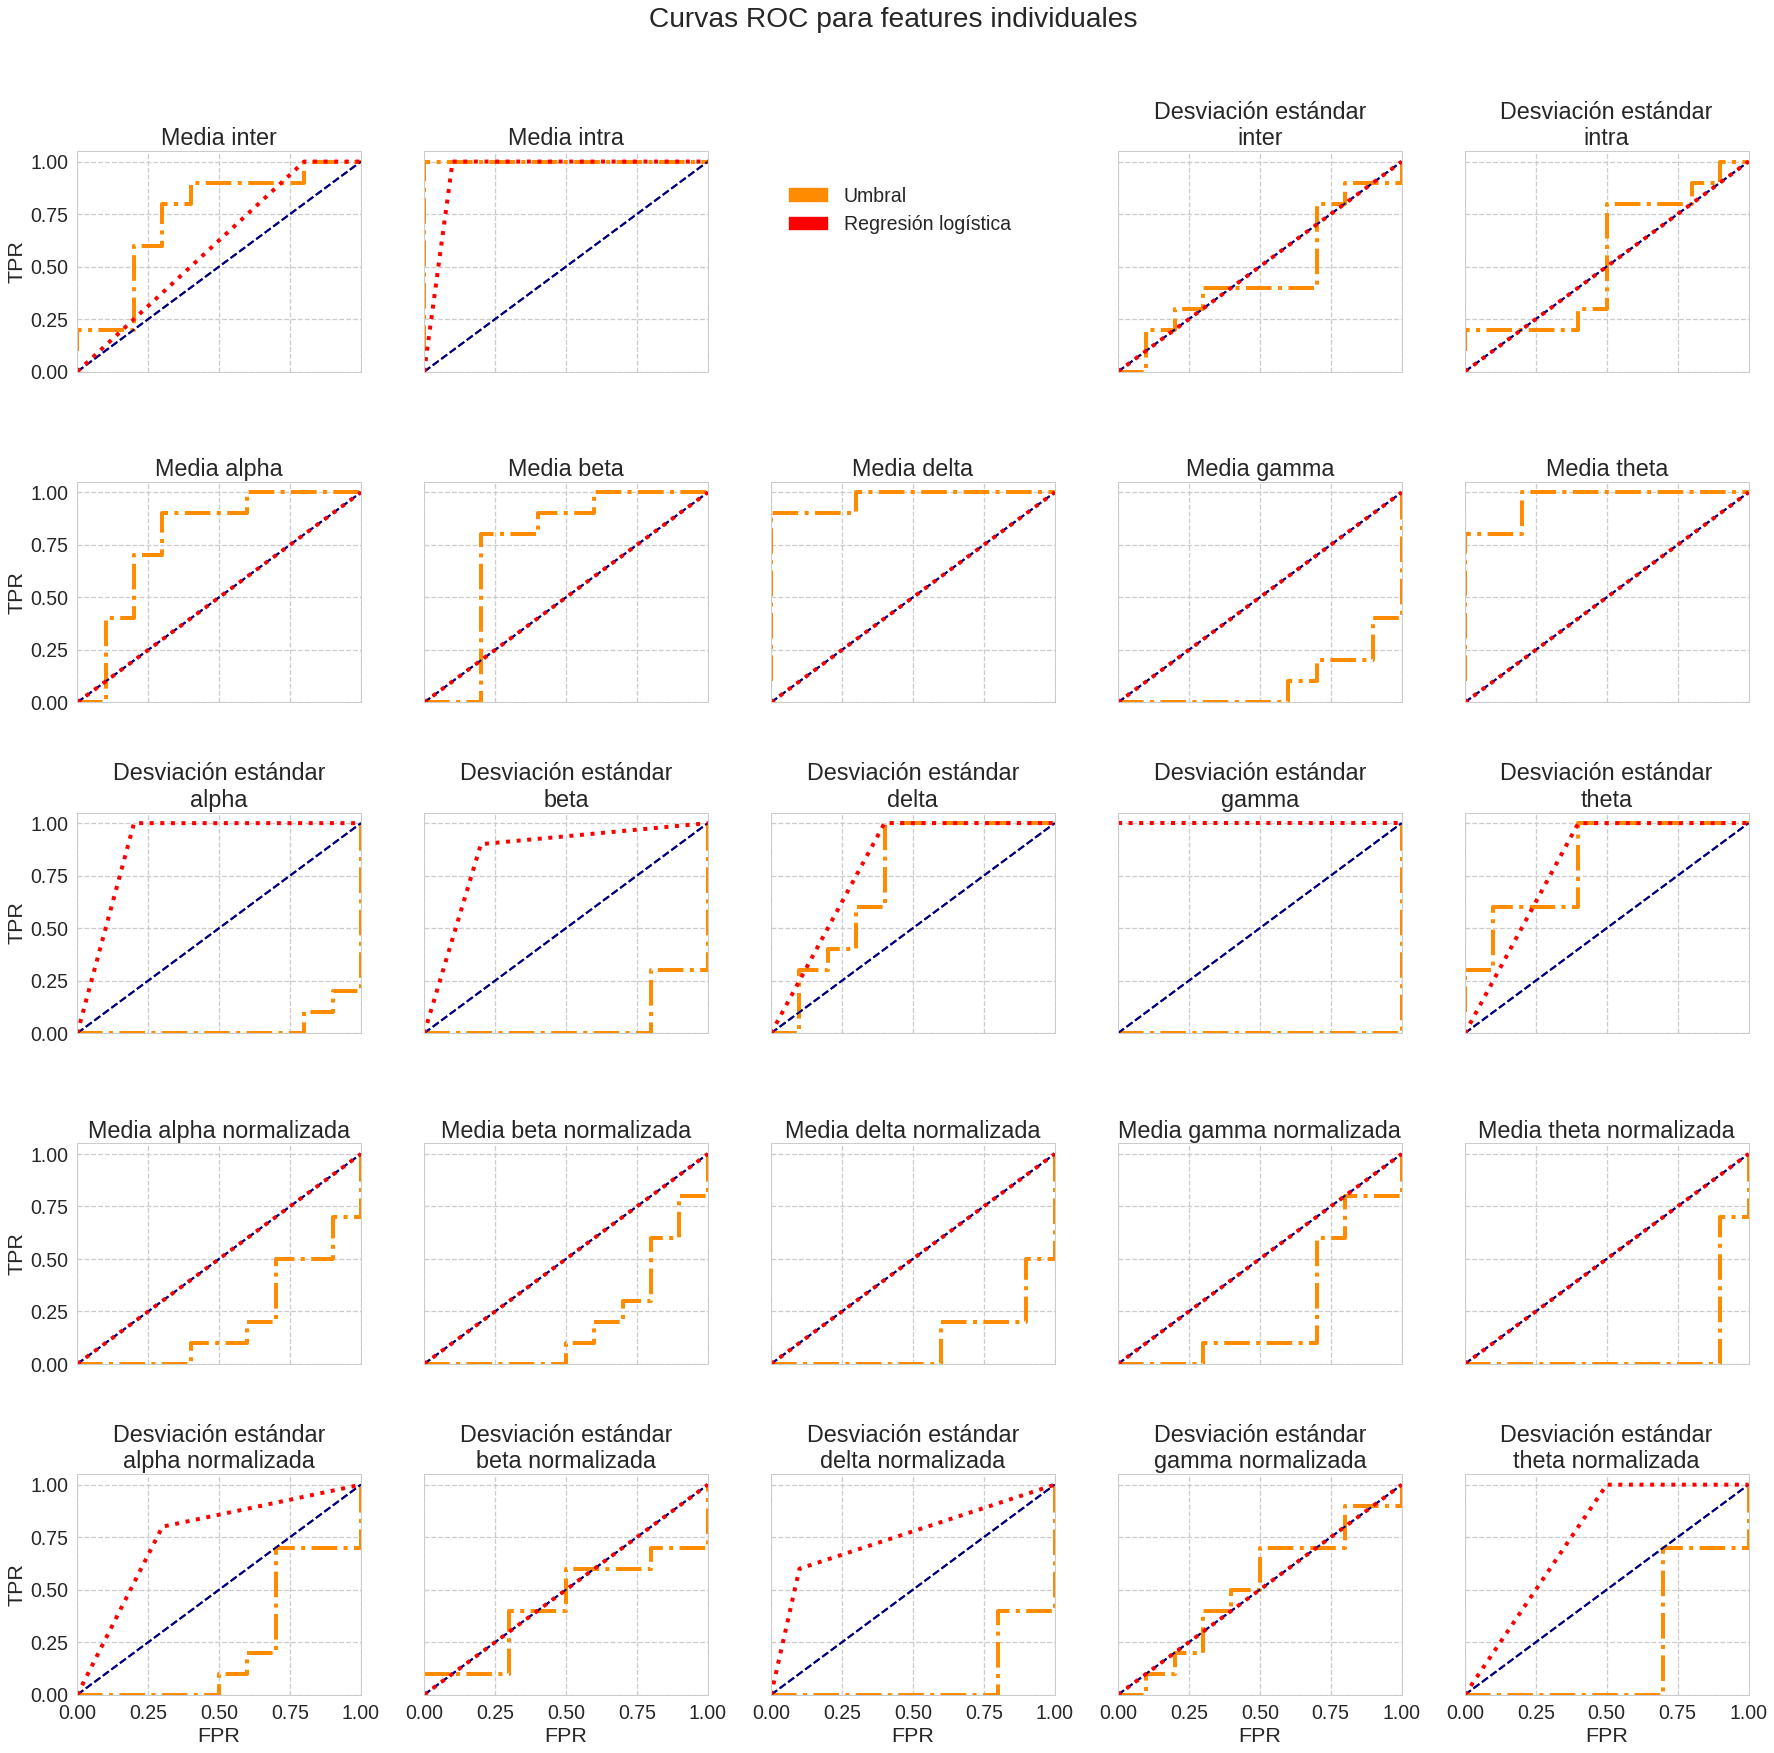

In [38]:
plt.close()

axes = dict()
fig = plt.figure(figsize=(25,25))
for son_bandas, l in [(True, c_bandas+c_bandas_norm), (False, c_entropia)]:
    for j, c in enumerate(l):
        if son_bandas:
            i = (0 if c[0] == "media" else 1) + (2 if j >=10 else 0) + 1
            j = j % 5
        else:
            i = 0
            j = j if j < 2 else (j+1)

        ax = plt.subplot2grid((5,5), (i,j))
        axes[c] = ax
        if i == 4:
            ax.set_xlabel('FPR')
        else:
            ax.xaxis.set_major_formatter(NullFormatter())

        if j == 0:
            ax.set_ylabel('TPR')
        else:
            ax.yaxis.set_major_formatter(NullFormatter())

df_metricas = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(list(zip(*sorted(c_bandas + c_bandas_norm + c_entropia)))))
analisis_univariado(df_features, df_metricas, axes)
analisis_regresion_logistica(df_features, df_metricas, axes)

p_reg_log = mpatches.Patch(color='red')
p_umbral = mpatches.Patch(color='darkorange')
fig.legend(
    labels=['Umbral', 'Regresión logística'],
    handles=[p_umbral, p_reg_log],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.88)
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.9)
plt.suptitle("Curvas ROC para features individuales")

plt.show()

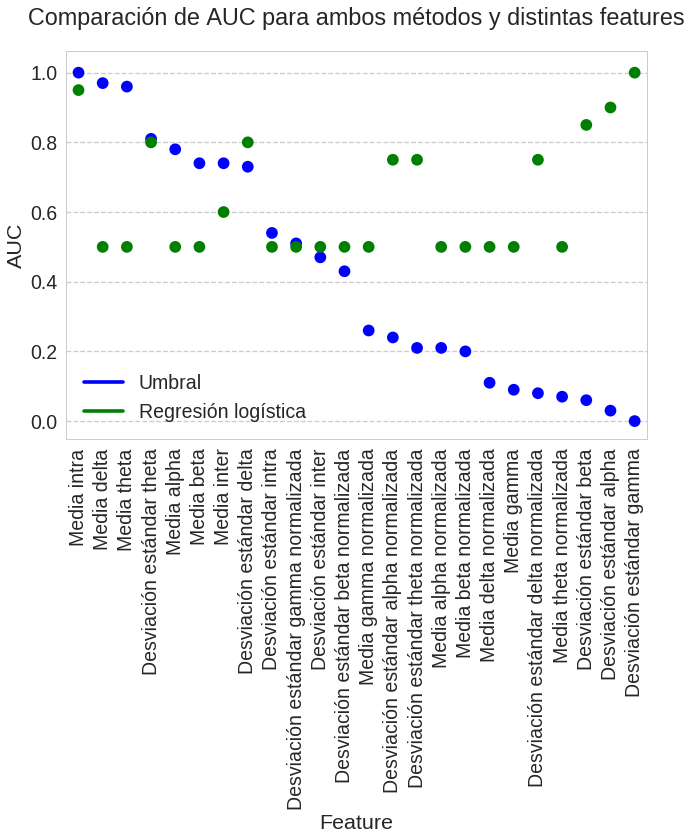

In [9]:
c_feature = "Feature"
df_auc = df_metricas.reset_index()
df_auc[c_feature] =  (df_auc["level_0"] + " " + df_auc["level_1"]).apply(nombre_bonito)

c_umbral = "Umbral"
c_reg_log = "Regresión logística"
c_feature = "Feature"
df_auc.rename(columns={"umbral_auc": c_umbral, "regLog_auc": c_reg_log}, inplace=True)
df_auc = df_auc[[c_feature, c_umbral, c_reg_log]].sort_values(c_umbral, ascending=False)

f, ax = plt.subplots(1, 1)
args = {
    "data": df_auc,
    "ax": ax,
    "x": c_feature,
    "join": False
}

plt.xticks(rotation=90)
sns.pointplot(y=c_umbral, color='blue', **args)
sns.pointplot(y=c_reg_log, color='green', **args)
ax.legend(handles=ax.lines[::len(df_auc)+1], labels=["Umbral","Regresión logística"])

plt.ylabel("AUC")
ttl = plt.title("Comparación de AUC para ambos métodos y distintas features")
ttl.set_position([.5, 1.05])

plt.show()
    

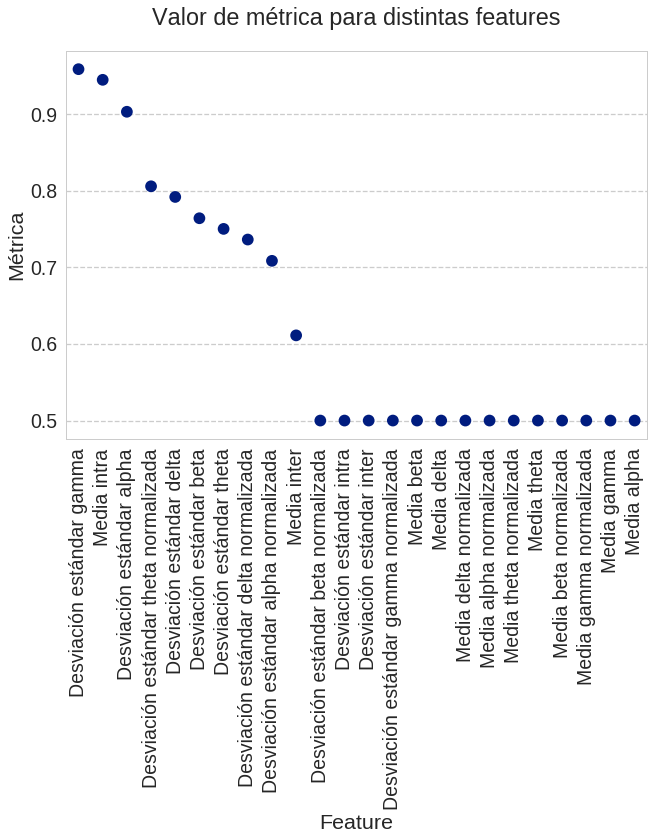

In [10]:
c_feature = "Feature"
df_reg_log = df_metricas.reset_index()
df_reg_log[c_feature] =  (df_reg_log["level_0"] + " " + df_reg_log["level_1"]).apply(nombre_bonito)
    
c_metrica = "Métrica"
df_reg_log.rename(columns={"regLog_score": c_metrica}, inplace=True)
df_reg_log = df_reg_log[[c_feature, c_metrica]].sort_values(c_metrica, ascending=False)

plt.xticks(rotation=90)
sns.pointplot(x=c_feature, y=c_metrica, data=df_reg_log, join=False)

plt.ylabel(c_metrica)
ttl = plt.title("Valor de {} para distintas features".format(c_metrica.lower()))
ttl.set_position([.5, 1.05])

plt.show()

<h1>Análisis multivariado</h1>
<p>

In [20]:
X = df_features.drop(("valor_real", ""), axis=1)
Y = df_features["valor_real"]


In [88]:
def analisis_modelo(fitted_clf, X, Y):
    classes_prob = clf.predict_proba(X)
    
    # REVISAR BIEN QUE CLASES ES LA QUE QUIERO AGARRAR
    # HAY QUE AGARRAR LA PROBABILIDAD QUE CORRESPONDA A LA CLASE "POSITIVA"
    
    predicted = classes_prob[:,1]

    scores = model_selection.cross_val_score(clf, X, Y)
    final_score = sum(scores) / len(scores)
    print("Score obtenido con validación cruzada: {:0.2f}".format(final_score))

    f, ax = plt.subplots(1, 1)
    plot_args = {
        "color": "black",
        "ls": ":"
    }

    auc = threshold_ROC(Y.values, predicted, "SVM", ax=ax, **plot_args)
    plt.show()
    print("AUC obtenido:", auc)

Score obtenido con validación cruzada: 0.94


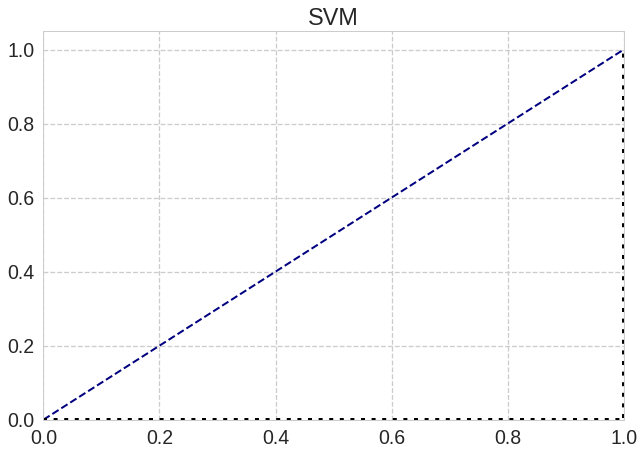

AUC obtenido: 0.0


In [90]:
# 2.a Support Vector Machine
clf = SVC(probability=True)
clf.fit(X,Y)

analisis_modelo(clf, X, Y)

Score obtenido con validación cruzada: 1.00


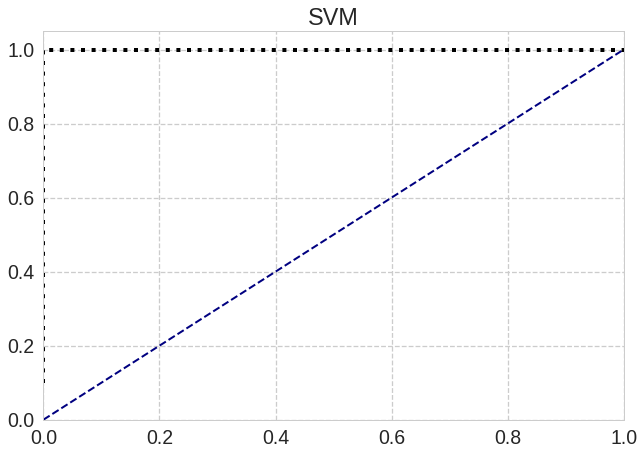

AUC obtenido: 1.0
tipo  indice_paciente
P     0                  1
      1                  1
      2                  1
      3                  1
      4                  1
      5                  1
      6                  1
      7                  1
      8                  1
      9                  1
S     0                  0
      1                  0
      2                  0
      3                  0
      4                  0
      5                  0
      6                  0
      7                  0
      8                  0
      9                  0
Name: valor_real, dtype: int64
[[ 0.11670503  0.88329497]
 [ 0.04858437  0.95141563]
 [ 0.02917184  0.97082816]
 [ 0.1134053   0.8865947 ]
 [ 0.05400764  0.94599236]
 [ 0.07820136  0.92179864]
 [ 0.0483036   0.9516964 ]
 [ 0.09755454  0.90244546]
 [ 0.13842157  0.86157843]
 [ 0.05340336  0.94659664]
 [ 0.95177565  0.04822435]
 [ 0.93834844  0.06165156]
 [ 0.94053693  0.05946307]
 [ 0.93552991  0.06447009]
 [ 0.847051

In [91]:
# SVM pipeline

steps = [
    ("preprocesamiento", MinMaxScaler()),
    ("selector_features", SelectKBest(k=2)),
    ("svm", SVC(probability=True))
]

clf = Pipeline(steps)
clf.fit(X,Y)

analisis_modelo(clf, X, Y)

print(Y)
print(clf.predict_proba(X))
